# Imports

In [ ]:
!pip install shap

In [129]:
import pandas as pd
import numpy as np
#import pandahouse as ph
from datetime import date

from tqdm.auto import tqdm

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from joblib import dump, load

import shap

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

#Load data. EDA

In [4]:
# load end see data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/(Olds_from_FF) HACKATHON BEST URFU’21/Main Project/hackathon-spring-2021.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.



,social_type,text,has_images,has_videos,url,likes,comments,reposts,views,is_repost,created_date,updated_date,version,author_id,id,author_subscribers
0,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,20,2,0,-1,0,2021-04-07 06:30:00,2021-04-07 16:40:11,2,42559086985346,group/42559086985346/topic/152651712709506,682150
1,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-07 06:30:00,2021-04-08 15:07:33,4,42559086985346,group/42559086985346/topic/152651712709506,682138
2,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-09 05:17:45,6,42559086985346,group/42559086985346/topic/152651712709506,682137
3,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-09 17:17:49,8,42559086985346,group/42559086985346/topic/152651712709506,682149
4,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-10 06:12:21,10,42559086985346,group/42559086985346/topic/152651712709506,682149


In [5]:
df.shape

(328572, 16)

In [6]:
# all time data to need format
df['updated_date'] = pd.to_datetime(df['updated_date'])
df['created_date'] = pd.to_datetime(df['created_date'])

In [130]:
# # посмотрим надоли лайков, репостов, комментарий, просмотров (относитльно аудитории)
data_with_allfullINFO = df.query('likes >= 0 and reposts >= 0 and comments >= 0 \
                                  and author_subscribers > 0 and views > 0 and author_subscribers >= views')
per_repost = []
per_like = []
per_comm = []
reach = []
for id in tqdm(data_with_allfullINFO['id'].unique()):
    curr_data = data_with_allfullINFO[data_with_allfullINFO['id'] == id]
    max_subscribers = curr_data['author_subscribers'].max()
    per_like += [curr_data['likes'].max() / max_subscribers]
    per_repost += [curr_data['reposts'].max() / max_subscribers]
    per_comm += [curr_data['comments'].max() / max_subscribers]
    reach += [curr_data['views'].max() / max_subscribers]

To output multiple subplots, the figure containing the passed axes is being cleared
To output multiple subplots, the figure containing the passed axes is being cleared


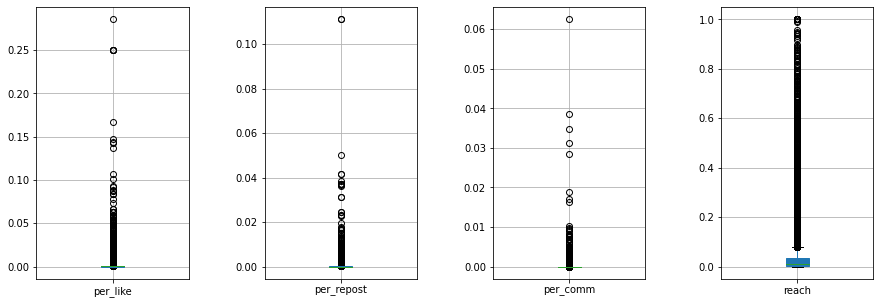

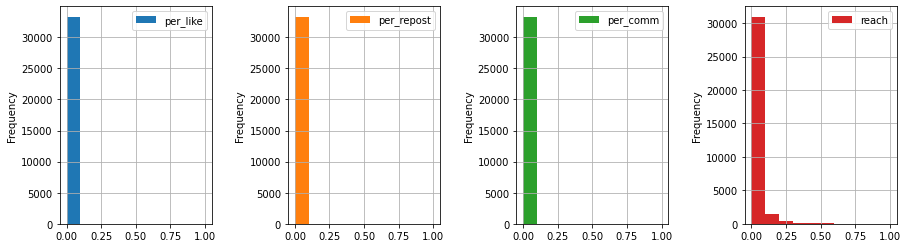

In [136]:
a = pd.DataFrame({'per_like': per_like, 'per_repost': per_repost, 'per_comm': per_comm, 'reach':reach})
# subplots boxplot
_, ax = plt.subplots(figsize=(15,5), facecolor='w')
a.plot(subplots=True, layout=(1,4), kind='box', grid=True, patch_artist=True, ax=ax)
plt.subplots_adjust(wspace=0.5);

# subplots hist
_, ax = plt.subplots(figsize=(15,4), facecolor='w')
a.plot(subplots=True, layout=(1,4), kind='hist', grid=True, ax=ax)
plt.subplots_adjust(wspace=0.5);

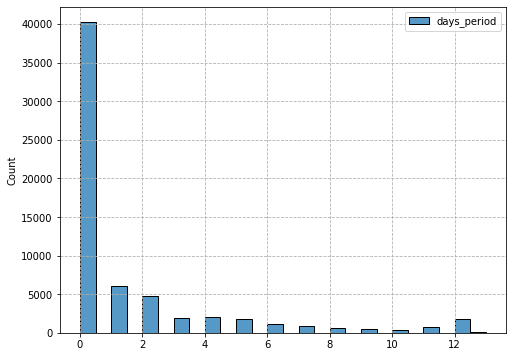

In [ ]:
# гистограмма периодов, за которые были измерены данные в днях

In [24]:
# нам интересны случаи когда есть просмотры и подписчики
data_with_fullINFO = df.query('author_subscribers > 0 and views > 0 and author_subscribers >= views')

# т.к. данных и так мало, то будем предсказывать не на неделю, а на день

init_cols = ['social_type', 'text', 'has_images', 'has_videos', 'url', 
             'is_repost', 'created_date', 'author_id', 'id']
series_cols = set(list(df.columns)) - set(init_cols)

learn_data = []
series_data = []
#todo: добавить сюда временные ряды для подходящих данных

for id in tqdm(data_with_fullINFO['id'].unique()):
    # chose only need info abot one post
    need_df = data_with_fullINFO[data_with_fullINFO['id'] == id]
    need_df = need_df.sort_values(by=['updated_date'], ignore_index=True)
    
    # add info about obhvat after week 
    created_date = need_df['created_date'][0]
    updated_date = need_df['updated_date']
    period = updated_date - created_date

    if np.any(period.dt.days >= 1):
        # находим данные за семь дней
        ind = period.index[(period.dt.days - 1).abs().argsort()[:2]]
        
        init_data = need_df.loc[0, init_cols].to_frame().T
        views = need_df['views']
        subscribers = need_df['author_subscribers']
        init_data['author_subscribers_init'] = subscribers[0]
        init_data['author_subscribers_week'] = subscribers[ind[-1]]
        init_data['views_week'] = views[ind[-1]]
        learn_data += [init_data]
        series_data += [need_df[series_cols].reset_index()]

#Let's try estimate

##попробуем кластеризацию текста

In [ ]:
# попробуем кластеризацию текста

In [ ]:
!pip install mpld3

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
dict_data_morehalfday['init_info'][0]

NameError: ignored

In [ ]:
dict_data['init_info']

#удалим все знаки препинания и цифры
for line in titles:
    chis = re.sub(r'(\<(/?[^>]+)>)', ' ', line)
    #chis = re.sub()
    chis = re.sub('[^а-яА-Я ]', '', chis)
    posti.append(chis)

##Create dataset

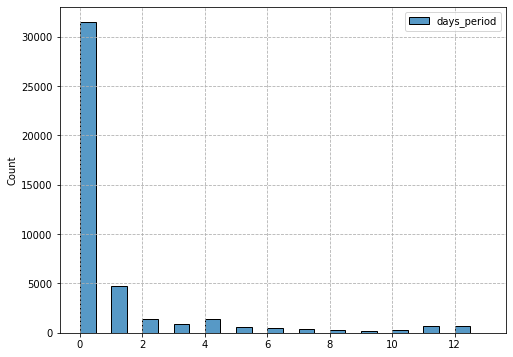

In [ ]:
# гистограмма периодов, за которые были измерены данные 
period = []
dict_data_morehalfday = {'init_info': [], 'series_data': []}
for i in tqdm(range(len(dict_data['series_data']))):
    data = dict_data['series_data'][i]['updated_date']
    period += [data[len(data)-1] - data[0]]

    if period[-1].seconds // 3600 >= 12:
        dict_data_morehalfday['init_info'] += [dict_data['init_info'][i]]
        dict_data_morehalfday['series_data'] += [dict_data['series_data'][i]]

_, ax = plt.subplots(figsize=(8,6))
sns.histplot(pd.DataFrame({'days_period':list(map(lambda x: x.days, period))}), binwidth=0.5, ax=ax)
ax.grid(linestyle='--')

In [51]:
X = pd.concat(learn_data)
#X = X[X['author_subscribers_week'] >= X['views_week']]
print(X.shape)
num_cols = ['has_images', 'has_videos', 'author_id', 'author_subscribers_init', 
            'author_subscribers_week', 'views_week']
X[num_cols] = X[num_cols].astype(float)
X[['is_repost', 'author_id']] = X[['is_repost', 'author_id']].astype(int)
X.info()

(11856, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11856 entries, 0 to 0
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   social_type              11856 non-null  object        
 1   text                     11440 non-null  object        
 2   has_images               11856 non-null  float64       
 3   has_videos               11856 non-null  float64       
 4   url                      11856 non-null  object        
 5   is_repost                11856 non-null  int64         
 6   created_date             11856 non-null  datetime64[ns]
 7   author_id                11856 non-null  int64         
 8   id                       11856 non-null  object        
 9   author_subscribers_init  11856 non-null  float64       
 10  author_subscribers_week  11856 non-null  float64       
 11  views_week               11856 non-null  float64       
dtypes: datetime64[ns](1), fl

In [ ]:
X.head()

In [52]:
def pred_pross(X):
    # находим обхват за неделю
    X['reach'] = X['views_week'] / X['author_subscribers_week']
    # добавляем информацию о дне недели и часа даты создания
    X['day_of_week'] = X['created_date'].dt.dayofweek
    X['hour'] = X['created_date'].dt.hour
    # one hot enc для соцсети
    X = pd.concat([X, pd.get_dummies(X['social_type'], prefix='social_type')], 
                  axis=1)

    X.drop(['social_type'], axis=1, inplace=True)
    return X 

In [53]:
X = pred_pross(X)
X.head()

,text,has_images,has_videos,url,is_repost,created_date,author_id,id,author_subscribers_init,author_subscribers_week,views_week,reach,day_of_week,hour,social_type_telegram,social_type_vk
0,https://svo.spb.ru/1abzats/v-bolgarii-obyasnil...,0.0,0.0,https://t.me/AAAAAFMSqM/1574,0,2021-04-06 22:08:49,86948,2546168242615879164,2.0,2.0,1.0,0.5,1,22,1,0
0,https://svo.spb.ru/1abzats/mironov-predlozhil-...,0.0,0.0,https://t.me/AAAAAFMSqM/1575,0,2021-04-06 22:41:59,86948,2546184935945799165,2.0,2.0,1.0,0.5,1,22,1,0
0,https://svo.spb.ru/1abzats/v-mvd-razyasnili-vo...,0.0,0.0,https://t.me/AAAAAFMSqM/1576,0,2021-04-07 06:48:34,86948,2546429841356359608,2.0,2.0,1.0,0.5,2,6,1,0
0,https://svo.spb.ru/1abzats/drozdenko-soobshhil...,0.0,0.0,https://t.me/AAAAAFMSqM/1577,0,2021-04-07 06:49:20,86948,2546430227232327609,2.0,2.0,1.0,0.5,2,6,1,0
0,https://svo.spb.ru/1abzats/myortvaya-voda-kryma/,0.0,0.0,https://t.me/AAAAAFMSqM/1578,0,2021-04-07 07:03:35,86948,2546437399492167610,2.0,2.0,1.0,0.5,2,7,1,0


In [97]:
x = X[set(X.columns) - {'text', 'url', 'author_subscribers_week', 'views_week', 
                        'created_date', 'id', 'reach', 'day_of_week'}]
print(x.shape)
x.head()

(11856, 8)


,has_videos,social_type_telegram,social_type_vk,author_id,author_subscribers_init,is_repost,has_images,hour
0,0.0,1,0,86948,2.0,0,0.0,22
0,0.0,1,0,86948,2.0,0,0.0,22
0,0.0,1,0,86948,2.0,0,0.0,6
0,0.0,1,0,86948,2.0,0,0.0,6
0,0.0,1,0,86948,2.0,0,0.0,7


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


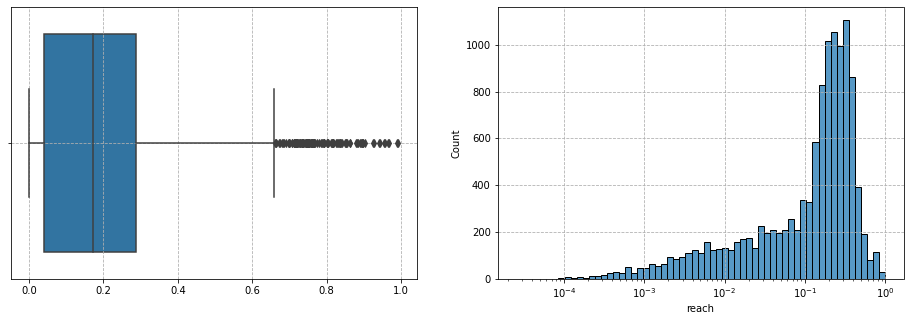

In [157]:
_, ax = plt.subplots(ncols=2, facecolor='w', figsize=(16,5))
sns.boxplot(X['reach'], orient="h", ax=ax[0])
sns.histplot(X['reach'], ec='k', log_scale=True, ax=ax[1])
ax[0].set_xlabel(None)
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
plt.show()

In [93]:
def make_query_dataset(has_videos, has_images, social_type,	author_id, is_repost,
                       create_data, author_subscribers_init):
    '''
    has_videos --> int, (0 -- False, 1 -- True)
    has_images --> int, (0 -- False, 1 -- True)
    social_type --> str ('vk', 'telegram')
    author_id --> int
    is_repost --> int, (0 -- False, 1 -- True)
    create_data --> data in str, format '%Y-%m-%d %H:%M:%S'
    author_subscribers_init --> int,
    '''
    create_data = datetime.datetime.strptime(create_data, '%Y-%m-%d %H:%M:%S')
    if social_type == 'telegram':
        social_type_telegram = 1
        social_type_vk = 0
    elif social_type == 'vk':
        social_type_telegram = 0
        social_type_vk = 1
    df = pd.DataFrame({'has_videos': [int(has_videos)],
                       'social_type_telegram': [social_type_telegram],
                       'social_type_vk': [social_type_vk],
                       'author_id': [int(author_id)],
                       'author_subscribers_init': [int(author_subscribers_init)],
                       'is_repost': [int(is_repost)],
                       'has_images': [int(has_images)],
                       'hour': [create_data.hour]})
    return df

In [ ]:
# загружаем сохраненную модель в формате .joblib
model = pickle.load(open('model.pkl', 'rb'))

# функция для предсказания потенциального охвата
def predict_reach_by_day(input_df, model):
    ''' 
    input_df --> DataFrame, данные пользователя из функции make_query_dataset
    model --> fit model 
    '''
    y_pred = model.predict(input_df.values)
    return y_pred


# дата создания поста, которую вводит пользователь create_data
create_data_dt = datetime.datetime.strptime(create_data, '%Y-%m-%d %H:%M:%S')

# массивы для отрисовки графика
x = [create_data_dt, 
     create_data_dt + datetime.timedelta(days=1)]
y = [0, y_pred] # y_pred = predict_reach_by_day(input_df, model)

##Fit

In [123]:
dump(grid_result.best_estimator_, 'best_regressor_xgboost.joblib') 

['best_regressor_xgboost.joblib']

In [45]:
mse = make_scorer(mean_squared_error, average='macro')

In [100]:
gsc = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={"learning_rate": (0.05, 0.10),
                        "max_depth": [ 3, 4],
                        "min_child_weight": [3, 5, 7],
                        "gamma": [0.0],
                        "colsample_bytree":[0.3, 0.4],},
            cv=5, verbose=0, n_jobs=-1)

grid_result = gsc.fit(x.values, X['reach'])

[06:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [101]:
grid_result.best_params_  # for the first y_target estimator

{'colsample_bytree': 0.3,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 5}

In [102]:
grid_result.best_score_

0.1210642975705464

In [103]:
y_pred = grid_result.best_estimator_.predict(x.values)
y_real = X['reach']

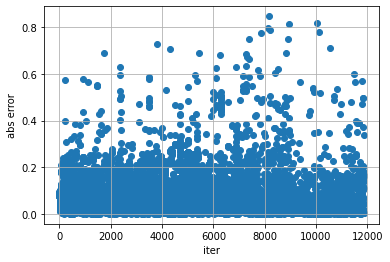

In [155]:
_, ax = plt.subplots(facecolor='w')
ax.scatter(np.arange(len(y_pred)), abs(y_real-y_pred))
ax.set_xlabel('iter')
ax.set_ylabel('abs error')
ax.grid()

In [105]:
r2_score(y_real, y_pred)

0.4654608255116778

In [106]:
mean_absolute_error(y_real, y_pred)

0.08126124751377697

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


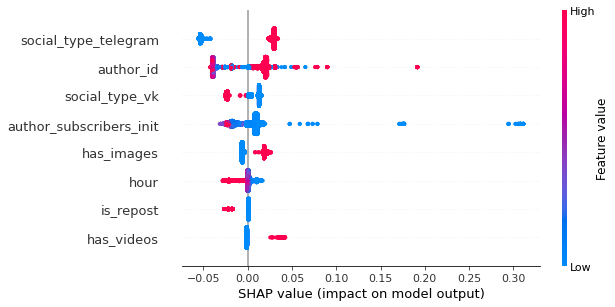

In [108]:
shap_test = shap.TreeExplainer(grid_result.best_estimator_).shap_values(x)
shap.summary_plot(shap_test, x, #features=[]
                  max_display=25, auto_size_plot=True)